# Analytic interlopers
10 October 2019

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy.constants as c
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value

from numpy.random import normal

# CAMB's comoving distance function
# import sys
# sys.path.append('/n/home13/atsang/gadget4/notebooks/')
# from run_camb import get_comdist_func, get_easy_density_func
# # note: get_comdist_func is a function of z, get_density_func is a function of a
# plt.switch_backend('module://ipykernel.pylab.backend_inline')

from scipy.special import j0
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d, interp2d
from scipy.misc import derivative

import mpmath # todo: play around with this

cosmo = FlatLambdaCDM(H0=70, Om0=0.316)

## Comoving distances
Using $z_l = 0.5$ as our default.

We can calculate $\Sigma_{cr}$ thus:
$$\Sigma_{cr} = \frac{c^2 D_s}{4\pi G D_{ds}D_d}$$

In [2]:
z_source = 1
z_lens = 0.5

a_source = 1/(1+z_source)
a_lens = 1/(1+z_lens)

chi_source = cosmo.comoving_distance(z_source) # (not /h)
chi_lens = cosmo.comoving_distance(z_lens) # (not /h)

D_s = a_source * chi_source
D_l = a_lens * chi_lens
D_ls = a_source * (chi_source - chi_lens) # this works because space is flat

sigma_crit = c.c**2 * D_s / (4 * np.pi * c.G * D_ls * D_l)
sigma_crit = sigma_crit.to(u.Msun/u.kpc**2)
sigma_crit

<Quantity 3.11639352e+09 solMass / kpc2>

Arbitrary Einstein radius

In [3]:
#### theta_E = np.sqrt(4 * c.G * mass_l / c.c**2 * D_ls / (D_l * D_s)).si
theta_E = 1.0 * np.pi/648000 # 1 arcsec
print(theta_E, 'radians')
print(theta_E * D_l.to(u.kpc))

4.84813681109536e-06 radians
6.070727349384301 kpc


In [42]:
phi_E = theta_E * cosmo.comoving_distance(z_lens) / (cosmo.comoving_distance(z_source)-cosmo.comoving_distance(z_lens))
def cone_R_units(z):
    # returns a comoving distance
    forwards_cone_R = 2 * theta_E * cosmo.comoving_distance(z)
    backwards_cone_R = 2 * phi_E * (cosmo.comoving_distance(z_source) - cosmo.comoving_distance(z))
    return np.minimum(forwards_cone_R, backwards_cone_R).to(u.kpc)

def cone_R_kpc_slow(z):
    return cone_R_units(z).to(u.kpc).value

In [43]:
z_vals = np.linspace(0,1,1000)
cone_R_kpc = interp1d(z_vals, cone_R_kpc_slow(z_vals))

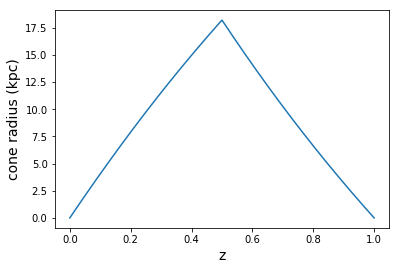

In [44]:
plt.plot(z_vals, cone_R_kpc(z_vals))
plt.xlabel('z', size=14)
plt.ylabel('cone radius (kpc)', size=14)
plt.show()

In [7]:
# %%time
# for i in range(1000):
#     cone_R_kpc_slow(z_vals)

# %%time
# for i in range(1000):
#     cone_R_kpc(z_vals)

### Derivative $d\chi / dz$
We'll interpolate to save time while integrating

In [8]:
z_vals = np.linspace(1e-5,1-1e-5,200)
dchi_dz_func = interp1d(z_vals, 1000*derivative(cosmo.comoving_distance, z_vals, dx=.00001)) # in terms of kpc (cosmo.comoving_distance was in Mpc)

In [9]:
quad(dchi_dz_func, 0, 1)

(3273040.465985017, 0.0010850666121287622)

Text(0.5, 0, 'z')

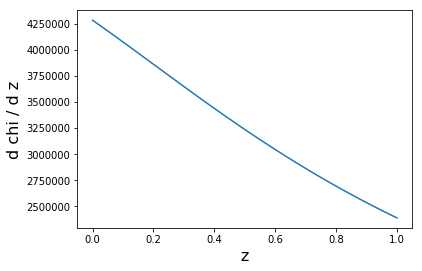

In [10]:
plt.plot(z_vals, dchi_dz_func(z_vals))
plt.ylabel('d chi / d z', size=16)
plt.xlabel('z', size=16)

## Effective masses

[//]: # (**Note** : This numpy file we're about to load assumes that $z_l = 0.5$ and $z_s = 1.0$. Also, what a weird comment syntax!)

We're not using Despali's mass function anymore.

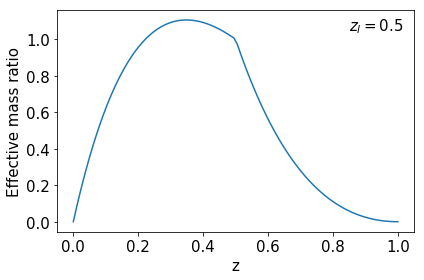

In [11]:
def meff_func(z_inter):
    # z_inter is the redshift of the interloper
    a_inter = 1/(1+z_inter)
    chi_inter = cosmo.comoving_distance(z_inter)
    D_i = a_inter * chi_inter
    D_is = a_source * (chi_source - chi_inter)
    
    if z_inter == z_lens:
        return 1
    elif z_inter < z_lens: # foreground interloper
        return D_i * D_is / D_l / D_ls
    else: # background interloper
        D_li = a_inter * (chi_inter - chi_lens)
        return (1-D_li*D_s/D_i/D_ls)*D_i*D_is/D_l/D_ls

z_vals = np.linspace(0,1,100)
meff_vals = np.array([meff_func(z) for z in z_vals])

plt.plot(z_vals, meff_vals)
plt.text(.85,1.05,'$z_l = 0.5$',size=15)
plt.xlabel('z',fontsize=15)
plt.ylabel('Effective mass ratio',fontsize=15)
plt.gca().tick_params(labelsize=15)
plt.tight_layout()
#plt.savefig('imgs/effective_mass_dec10.pdf')
plt.show()

In [12]:
# define meff_ratio_func as a linear interpolation (so this will be faster when it goes into the integral)
meff_ratio_func = interp1d(z_vals, meff_vals)

## Profile parameters
### Calculating $\rho_{cr}$
$\rho_{cr}$ as a function of $z$.

In [13]:
#easy_density_func = get_easy_density_func()

#print(easy_density_func(0).to(u.M_sun / u.Mpc**3))

#print(easy_density_func(1).to(u.M_sun / u.kpc**3))

### Radius ($r_s$ and $r_t$) values

The following lines are commented out because I'll be loading numpy objects from Cagan.

In [14]:
# mass_vals = np.logspace(-1,9,80) * u.M_sun
# mass_vals

# def rs_from_mass(mass):
#     # return mean, std
#     rs0 = 0.1 * u.kpc
#     m0 = 1e6 * u.M_sun
#     gamma = 1/3.
#     sigrs = 0.2
    
#     mu = rs0 * (mass/m0)**gamma
#     std = sigrs * mu
#     return (mu, std)

# def rt_from_mass_z(mass, z):
#     rho_crit = easy_density_func(z)
#     #print('about to return', (3*mass/(800 * np.pi * rho_crit))**(1/3))
#     return ((3*mass/(800 * np.pi * rho_crit))**(1/3)).to(u.kpc)

# rs_vals_m1to9delta = rs_from_mass(mass_vals)[0]
# rt_vals_m1to9delta = rt_from_mass_z(mass_vals, 0.5)

#### Values from Cagan
Anyway Cagan made a nice list of rs_rt values that should be sampled, so I'll just use that. Specifically, let's use the one assuming dirac delta. (See `feb14` version of this notebook for the more involved version.)

number of (rt,rs) pairs: 30


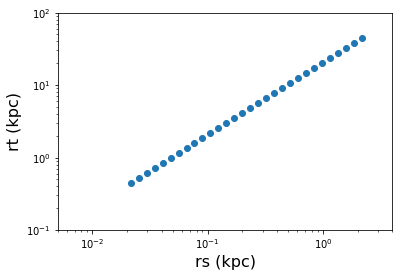

In [15]:
rt_rs_pairs = np.load('files/rt_rs_results/rt_vs_rs_assuming_dirac_delta.npy')
rt_vals_deltawide = rt_rs_pairs[:,1] * u.Mpc
rs_vals_deltawide = rt_rs_pairs[:,0] * u.Mpc

print('number of (rt,rs) pairs:',len(rs_vals_deltawide))

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.scatter(rs_vals_deltawide.to(u.kpc), rt_vals_deltawide.to(u.kpc))
plt.xlabel('rs (kpc)', size=16)
plt.ylabel('rt (kpc)', size=16)
plt.xlim(5e-3, 4e0)
plt.ylim(1e-1, 1e2)
plt.show()

## t-NFW Profile: $\hat \kappa$

In [16]:
def mass_by_massNFW(tau):
    # helper function to calculate kappa_hat
    return tau**2 / (1+tau**2)**2 * ((tau**2 - 1)*np.log(tau) + tau * np.pi - (tau**2+1))

def kappa_hat_kpc(rs, rt):
    def kappa_hat_r(r):
        '''
        Returns value of kappa_hat at r, in kpc^2 (todo: double-check units)
        
        Recall kappa_hat = Sigma_crit * kappa / m .
        We're not using astropy units (this function must be integrated)
        
        Also, note when we cast a complex down to a real,
        we've already mathematically guaranteed that those are real numbers,
        so it's safe to ignore the warning.
        '''

        x = r/rs
        tau = rt/rs
        
        # to calculate bigF:
        if isinstance(x, np.ndarray):
            x = np.array(x, dtype='complex')
            arccos = np.arccos
            sqrt = np.sqrt
            log = np.log
        elif isinstance(x, mpmath.mpf):
            x = mpmath.mpc(x)
            arccos = mpmath.acos
            sqrt = mpmath.sqrt
            log = mpmath.log
        else:
            x = complex(x)
            arccos = np.arccos
            sqrt = np.sqrt
            log = np.log
            
        bigF = arccos(1/x) / (x**2-1)**.5
        bigF = abs(bigF).real
        
        if isinstance(x, np.ndarray):
            x = np.array(x, dtype='float')
            bigF = np.array(bigF, dtype='float')
        elif isinstance(x, mpmath.mpc):
            x = x.real
            bigF = bigF.real
        else:
            x = abs(x)
            bigF = abs(bigF)
            
        bigL = log(x / (sqrt(tau**2 + x**2) + tau))

        prefactor = 1 / (rs**2) * tau**2 / (2*np.pi*(tau**2+1)**2)
        term1 = (tau**2+1)/(x**2-1) * (1-bigF)
        term2 = 2*bigF
        term3 = - np.pi / sqrt(tau**2 + x**2)
        term4 = (tau**2 - 1)/(tau * sqrt(tau**2 + x**2)) * bigL

        return 1/mass_by_massNFW(tau) * prefactor * (term1 + term2 + term3 + term4)
    return kappa_hat_r

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


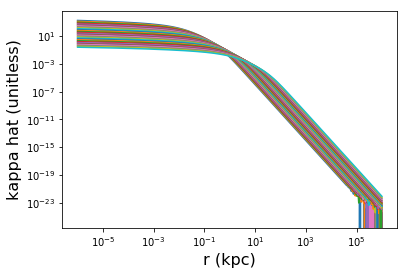

In [17]:
for rs,rt in zip(rs_vals_deltawide, rt_vals_deltawide): #zip(rs_vals_m1to9delta, rt_vals_m1to9delta):
    r_vals = np.logspace(-6,6,500)
    plt.loglog(r_vals, kappa_hat_kpc(rs.to(u.kpc).value, rt.to(u.kpc).value)(r_vals))
    
plt.xlabel('r (kpc)', size=16)
plt.ylabel('kappa hat (unitless)', size=16)
plt.show()

*Above* : Each color represents a different (rs, rt) pair, and the curves are the convergence profile of a single subhalo/interloper. Remember that the hat in $\hat \kappa$ means that we scale out the mass and $\Sigma_{cr}$ dependence.

## `quadosc` test
In this part, we test out MPMath's `quadosc` function. It's an integration method different from the regular `quad` which can greatly speed up integrals that involve Bessel functions. However, it is not always as accurate or as fast. 

Here, we want to calculate the integral from Equation 26 in arxiv:1707.04590 (Ana's paper):
$$\tilde \kappa(k) = 2\pi \int dr \cdot r J_0(kr) \hat \kappa(r)$$

In [18]:
def kappa_tilde_integrand_kpc(k, rs, rt):
    # assume all inputs are values in units of kpc already
    # output will be unitless anyway
    
    kappa_hat_r = kappa_hat_kpc(rs, rt)
    def integrand(r):
        return (2 * np.pi * r * mpmath.j0(k * r) * kappa_hat_r(r))
    return integrand

In [42]:
%%time
# fancy mpmath quadosc
k_list = np.logspace(-3,2,20) # 1/kpc

kappa_tildes_osc_big = np.zeros(len(k_list))
for i,k in enumerate(k_list):
    print('%.2f, '%k,end="")
    #j0zero = lambda n: mpmath.findroot(kappa_tilde_integrand_kpc(k, .1, 2), np.pi*(n-0.25))
    kappa_tildes_osc_big[i] = mpmath.quadosc(kappa_tilde_integrand_kpc(k, 2, 40),
                                     [0, mpmath.inf], 
                                     period=2*np.pi/k)
                                     #zeros=j0zero)
                                     #period=2*np.pi/k, error=True)

0.00, 0.00, 0.00, 0.01, 0.01, 0.02, 0.04, 0.07, 0.13, 0.23, 0.43, 0.78, 1.44, 2.64, 4.83, 8.86, 16.24, 29.76, 54.56, 100.00, CPU times: user 13.8 s, sys: 17.9 ms, total: 13.8 s
Wall time: 13.8 s


In [43]:
%%time
# regular scipy `quad`
k_list = np.logspace(-3,2,20) # 1/kpc

kappa_tildes_big = np.zeros([len(k_list),2])
for i,k in enumerate(k_list):
    print('%.2f, '%k,end="")
    kappa_tildes_big[i] = quad(kappa_tilde_integrand_kpc(k, 2, 40),
                                     0, np.inf, limit=1000)

0.00, 0.00, 0.00, 0.01, 0.01, 0.02, 0.04, 0.07, 0.13, 0.23, 0.43, 0.78, 1.44, 

/n/home13/atsang/.conda/envs/jup3/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


2.64, 4.83, 8.86, 16.24, 29.76, 54.56, 100.00, CPU times: user 1min 38s, sys: 39.8 ms, total: 1min 38s
Wall time: 1min 39s


Text(0.5, 1.0, 'Numerical integration test: rs=2, rt=40')

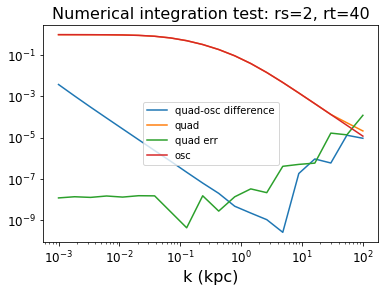

In [45]:
plt.loglog(k_list, np.abs(kappa_tildes_big[:,0]-kappa_tildes_osc_big), label='quad-osc difference')
plt.loglog(k_list, (kappa_tildes_big[:,0]), label='quad')
plt.loglog(k_list, kappa_tildes_big[:,1], label='quad err')
plt.loglog(k_list, (kappa_tildes_osc_big), label='osc')
plt.legend()
plt.xlabel('k (kpc)', size=16)
plt.title('Numerical integration test: rs=2, rt=40', size=16)

In [ ]:
%%time
# fancy mpmath quadosc
k_list = np.logspace(-3,2,20) # 1/kpc

kappa_tildes_osc = np.zeros(len(k_list))
for i,k in enumerate(k_list):
    print('%.2f, '%k,end="")
    #j0zero = lambda n: mpmath.findroot(kappa_tilde_integrand_kpc(k, .1, 2), np.pi*(n-0.25))
    kappa_tildes_osc[i] = mpmath.quadosc(kappa_tilde_integrand_kpc(k, .1, 2),
                                     [0, mpmath.inf], 
                                     period=2*np.pi/k)
                                     #zeros=j0zero)
                                     #period=2*np.pi/k, error=True)

In [ ]:
%%time
# regular scipy `quad`
k_list = np.logspace(-3,2,20) # 1/kpc

kappa_tildes = np.zeros([len(k_list),2])
for i,k in enumerate(k_list):
    print('%.2f, '%k,end="")
    kappa_tildes[i] = quad(kappa_tilde_integrand_kpc(k, .1, 2),
                                     0, np.inf, limit=1000)

In [ ]:
plt.loglog(k_list, np.abs(kappa_tildes[:,0]-kappa_tildes_osc), label='quad-osc difference')
plt.loglog(k_list, (kappa_tildes[:,0]), label='quad')
plt.loglog(k_list, kappa_tildes[:,1], label='quad err')
plt.loglog(k_list, (kappa_tildes_osc), label='osc')
plt.legend()
plt.xlabel('k (kpc)', size=16)
plt.title('Numerical integration test: rs=0.1, rt=2', size=16)

**Conclusion:** In terms of accuracy, regular `quad` is better for k < 1 kpc. For higher k, it's unclear, but probably `osc` is better. Also `quad` is faster for low k (roughly k < 1 kpc) and `osc` is much faster for high k (roughly k > 1 kpc).

**Good version demo**

In [46]:
%%time
k_list = np.logspace(-3,2,20) # 1/kpc

kappa_tildes_good = np.zeros(len(k_list))
for i,k in enumerate(k_list):
    print('%.2f, '%k,end="")
    if k > 1:
        kappa_tildes_good[i] = mpmath.quadosc(kappa_tilde_integrand_kpc(k, .1, 2),
                                         [0, mpmath.inf], 
                                         period=2*np.pi/k)
    else:
        kappa_tildes_good[i] = quad(kappa_tilde_integrand_kpc(k, .1, .2), 0, np.inf, limit=100)[0]

0.00, 0.00, 0.00, 0.01, 0.01, 0.02, 0.04, 0.07, 0.13, 0.23, 0.43, 0.78, 1.44, 2.64, 4.83, 8.86, 16.24, 29.76, 54.56, 100.00, CPU times: user 5.9 s, sys: 35.9 ms, total: 5.94 s
Wall time: 5.98 s


## 3D Fourier transform: $\tilde \kappa$

Don't need to run this every time -- can just load results!

In [26]:
def kappa_tilde_integrand_kpc(k, rs, rt):
    # assume all inputs are values in units of kpc already
    # output will be unitless anyway
    
    kappa_hat_r = kappa_hat_kpc(rs, rt)
    def integrand(r):
        return (2 * np.pi * r * mpmath.j0(k * r) * kappa_hat_r(r))
    return integrand

In [27]:
k_vals = np.logspace(-3,3,25) / u.kpc
#k_vals = np.array([1e-3]) / u.kpc
rs_vals = rs_vals_deltawide
rt_vals = rt_vals_deltawide # indexed together with rs
print('combos:',len(k_vals) * len(rs_vals))

combos: 750


In [ ]:
%%time

kappa_tildes = np.zeros([len(k_vals), len(rs_vals)])
for i,k in enumerate(k_vals):
    k = k.to(1/u.kpc).value
    print('%.2g, '%k,end="")
    for j,(rs, rt) in enumerate(zip(rs_vals, rt_vals)):
        rs, rt = rs.to(u.kpc).value, rt.to(u.kpc).value
        
        if k > 1:
            kappa_tildes[i,j] = mpmath.quadosc(kappa_tilde_integrand_kpc(k, rs, rt),
                                             [0, mpmath.inf], 
                                             period=2*np.pi/k)
        else:
            res = quad(kappa_tilde_integrand_kpc(k, rs, rt), 0, np.inf, limit=1000)
            kappa_tildes[i,j] = res[0]
            if res[1]/res[0] > .01:
                print('rel error',res[1]/res[0], 'for k', k, 'rs,rt', rs,rt)

In [129]:
"""
np.save('kappa_tildes_deltawide.npy', kappa_tildes)

np.save('kappa_tildes_k_deltawide.npy', k_vals.to(1/u.kpc).value)
np.save('kappa_tildes_rs_rt_deltawide.npy', np.array([rs_vals.to(u.kpc).value, rt_vals.to(u.kpc).value]).T)
"""

### Load previously-calculated $\tilde\kappa$ results

In [19]:
# load kappa_tilde results
kappa_tildes_matrix = np.load('files/kappa_tilde_results/kappa_tildes_deltawide.npy')
kappa_tildes_k = np.load('files/kappa_tilde_results/kappa_tildes_k_deltawide.npy') / u.kpc
kappa_tildes_rs_rt = np.load('files/kappa_tilde_results/kappa_tildes_rs_rt_deltawide.npy') * u.kpc

In [20]:
# plt.ylabel('k (1e-3 to 1e3 kpc^-1)', size=14)
# plt.xlabel('rs (2.2e-2 to 2.2 kpc)', size=14)
# plt.imshow(np.log10(kappa_tildes_matrix)); plt.colorbar()
# plt.show()

# *Above* : 2d plot of the $\tilde \kappa$ matrix (Fourier transform of $\hat\kappa$ profile), with color on a log-scale. 

# *This plot only works if the $(r_s, r_t)$-list implies a unique $r_t$ given $r_s$.*

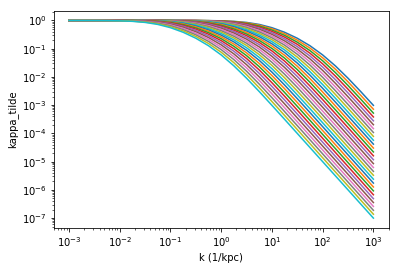

In [21]:
for j, (rs, rt) in list(enumerate(kappa_tildes_rs_rt)):
    plt.loglog(kappa_tildes_k, [kappa_tildes_matrix[i,j] for i in range(len(kappa_tildes_k))])
    #plt.loglog(k_list, [kappa_tildes[i,j][1] for i in range(len(k_list))])
plt.xlabel('k (1/kpc)')
plt.ylabel('kappa_tilde')
plt.show()

*Above* : Again, the different curves represent different (rs, rt) values, but now this is $\tilde \kappa$, the Fourier transform of $\hat \kappa$.

In [22]:
# # including integration errors
# for j, (rs, rt) in list(enumerate(kappa_tildes_rs_rt)):
#     plt.loglog(kappa_tildes_k, [kappa_tildes[i,j][0] for i in range(len(kappa_tildes_k))])
#     plt.loglog(kappa_tildes_k, [kappa_tildes[i,j][1] for i in range(len(kappa_tildes_k))])
# plt.xlabel('k (1/kpc)')
# plt.ylabel('kappa_tilde')
# plt.show()

In [23]:
# for i, k in enumerate(kappa_tildes_k):
#     plt.loglog(kappa_tildes_rs_rt[:,0], [kappa_tildes_matrix[i,j] for j in range(len(kappa_tildes_rs_rt))])

In [24]:
# kappa_tildes_matrix = np.zeros((len(kappa_tildes_k), len(kappa_tildes_rs_rt)))
# for i, k in enumerate(kappa_tildes_k):
#     for j, rs_rt in enumerate(kappa_tildes_rs_rt):
#         kappa_tildes_matrix[i,j] = kappa_tildes[i,j][0]

### Approximate mass vals
**Assume that $r_t | r_s$ follows a $\delta$-function.**

In [25]:
# If we didn't record what the mass vals were, we can approximate them like this
mass_vals = 1e6 * u.M_sun * (kappa_tildes_rs_rt[:,0] / (0.1 * u.kpc))**3
#print(mass_vals)

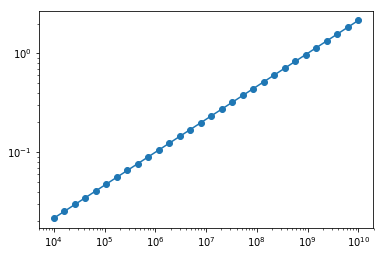

In [26]:
plt.loglog(mass_vals, kappa_tildes_rs_rt[:,0], 'o-')

In [27]:
# from scipy.optimize import curve_fit

# def linear(x, m, b):
#     return m * x + b
# popt, pcov = curve_fit(linear, np.log10(mass_vals/u.Msun), np.log10(kappa_tildes_rs_rt[:,0]/u.kpc))
# print(popt)

In [28]:
# has to be unitless because it goes in the integral
kappa_tilde_func = interp2d(kappa_tildes_k.to(1/u.kpc).value,
                            mass_vals.to(u.M_sun).value,
                            kappa_tildes_matrix.T,
                            bounds_error=True)

Text(0.5, 0, 'log10 mass')

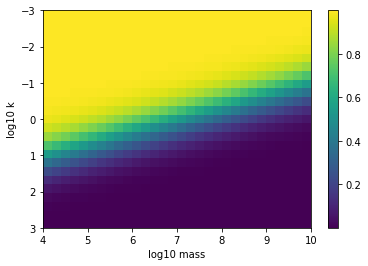

In [29]:
k_vals = kappa_tildes_k.to(1/u.kpc).value
plt.imshow(kappa_tildes_matrix, extent=(np.log10(min(mass_vals.value)),
                                        np.log10(max(mass_vals.value)),
                                       
                                        np.log10(max(k_vals)),
                                        np.log10(min(k_vals)),),
           aspect='auto')
plt.colorbar()
plt.ylabel('log10 k')
plt.xlabel('log10 mass')

## Cagan's Sheth-Tormen output

`massfunc` has units of 1/(Mpc/h)^3 / M_sun (comoving distance). `massesn` has units of $M_\odot$.

In [32]:
h = .675
massesn = np.load('files/st_results/0_massesn_ST.npy') # Msun
massfunc_matrix = np.load('files/st_results/0_massfunc_ST.npy') * h**3/1000**3 # convert Mpc/h^3 to 1/kpc^3
zs = np.load('files/st_results/0_redshifts_ST.npy')

massfunc = interp2d(zs, massesn, massfunc_matrix, bounds_error=True)

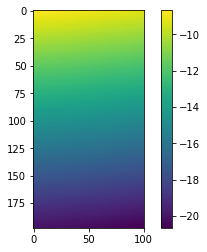

In [33]:
plt.imshow(np.log10(massfunc_matrix)); plt.colorbar()

*Above:* x-axis represents redshift; y-axis represents mass.

In [34]:
def massfunc_safe(z, mass):
    '''
    Pretend that the number density of galaxies heavier
    than our highest mass is exactly 0 (rather than throwing an error)
    '''
    if mass > massesn[-1]:
        return 0
    else:
        return massfunc(z, mass)

## Synthesis

Before we do the total integral, let's calculate a simplified version, just to get the order of magnitude
$$P(k) \approx \frac{1}{\Sigma_{cr}^2} \chi_s \int_{10^5}^{10^8} m^2 n(z_l, m) \left| \tilde\kappa(k, m) \right|^2 dm$$

In [35]:
sigma_crit = sigma_crit.to(u.Msun / u.kpc**2)

integral = quad(lambda m: m**2 * massfunc_safe(z_lens, m) * kappa_tilde_func(1e-3, m), 1e5, 1e8) # for k = 1e-3
print('integral error', integral[1]/integral[0])
1/sigma_crit**2 * chi_source.to(u.kpc) * integral[0] * u.Msun**2 * u.kpc**-3

integral error 0.001088494680866329


/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until


<Quantity 1.28703839e-05 kpc2>

In [36]:
klist = np.logspace(-3,2,10)
def calc_power_approx(k):
    return 1/sigma_crit**2 * chi_source.to(u.kpc) * quad(lambda m: m**2 * massfunc_safe(z_lens, m) * kappa_tilde_func(k, m), 1e5, 1e8)[0] * u.Msun**2 * u.kpc**-3

plist = [calc_power_approx(k).to(u.kpc**2).value for k in klist]

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until


$$P(k) \approx \frac{1}{\Sigma_{cr}^2} \int_0^1 dz \frac{d\chi}{dz} \frac{R^2(z)}{R^2(z_l)} \int_{10^5}^{10^8} m^2 n(z_l, m) \left| \tilde\kappa(k, m) \right|^2 dm$$

In [37]:
def calc_power_approx2(k):
    return ( 1/sigma_crit**2 * quad(lambda z:
                                  dchi_dz_func(z) # already in kpc
                                  * cone_R_kpc(z)**2 / cone_R_kpc(z_lens)**2, 0,1)[0] * u.kpc
       * quad(lambda m: m**2 * massfunc_safe(z_lens, m) * kappa_tilde_func(k, m), 1e5, 1e8)[0]
                                  * u.Msun**2 * u.kpc**-3 )

plist2 = [calc_power_approx2(k).to(u.kpc**2).value for k in klist]

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


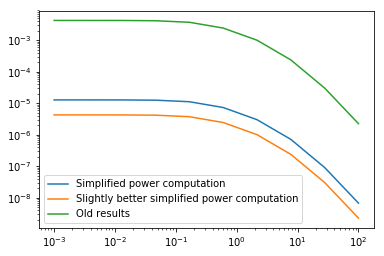

In [38]:
#plt.title('z_l = 2')
plt.loglog(klist, plist, label='Simplified power computation')
plt.loglog(klist, plist2, label='Slightly better simplified power computation')
plt.loglog(klist, np.array(plist2) * 1e3, label='Old results')
plt.legend()

Total integral:
$$\newcommand{\abs}[1]{{\left| #1 \right|}}$$
$$P_I(k) = \frac{\pi}{A \Sigma_\mathrm{cr}^2} \int_0^1 dz \int_{10^5}^{10^8} dm_\mathrm{eff}\, \left[\frac{dm}{dm_\mathrm{eff}}\right]_z m^2_\mathrm{eff}\, \frac{d\chi}{dz} R^2(z) n(z,m) \abs{\tilde \kappa_i(\frac{k}{F(z)}, m_\mathrm{eff})}^2$$
where $F(z) = \frac{R_{cone}(z_l)}{R_{cone}(z)} \geq 1$ represents the magnification from projecting to an effective convergence along a cone.
Here, $\frac{dm}{dm_\mathrm{eff}} = \frac{1}{\texttt{mass_ratio_func}(z)}$ and $m = \frac{m_\mathrm{eff}}{\texttt{mass_ratio_func}(z)}$.

In [50]:
cone_R_lens = cone_R_kpc_slow(z_lens)

def full_integrand_kpc(k, numerics_factor=1, ratio='full', meff_bool=True):
    '''
    The `numerics_factor` is multiplied to the final answer,
    which can make scipy's integration more accurate,
    but you have to remember to divide it out at the end!
    '''
    
    area = np.pi * cone_R_lens**2
    normalization = np.pi / (area * sigma_crit.to(u.M_sun/u.kpc**2).value**2)
    
    if ratio == 'full':
        rad_ratio_func = lambda cone_R: cone_R_lens / cone_R
    elif ratio == 'cutoff':
        rad_ratio_func = lambda cone_R: min(cone_R_lens / cone_R, 10)
    elif ratio == '1':
        rad_ratio_func = lambda cone_R: 1
    else:
        raise ValueError('ratio should be "full", "cutoff", or "1"')
        
    if meff_bool:
        my_meff_func = meff_ratio_func
    else:
        my_meff_func = lambda z : 1
    
    def integrand(z,meff):
        meff_factor = my_meff_func(z)
        dm_dmeff = 1/meff_factor
        dchi_dz = dchi_dz_func(z) # already kpc
        cone_R = cone_R_kpc(z)
        n = massfunc_safe(z,meff/meff_factor) # if physical mass is too high, will return 0
        rad_ratio = rad_ratio_func(cone_R)
        kap = kappa_tilde_func(k/rad_ratio, meff)
        
        ans = dm_dmeff * meff**2 * dchi_dz * cone_R**2 * n * kap**2
        
        return numerics_factor * normalization * ans
    
    return integrand

def calc_power_spec(k_vals, ratio, verbose=False, numerics_factor=1, meff_bool=True,
                   mass_range=(1e5,1e8)):
    full_integrands = np.zeros(len(k_vals)) #secretly units of M_sun^2
    full_errors = np.zeros(len(k_vals))
    
    if verbose: print('k, Power, Power rel err')
        
    for i, k in enumerate(k_vals):

        # dblquad ordering is a little weird: func(z,m), bounds of m, bounds of z (as functions of m)
        q = dblquad(full_integrand_kpc(k, numerics_factor=numerics_factor,
                                       ratio=ratio, meff_bool=meff_bool),
                    mass_range[0], mass_range[1],
                    lambda m: 0.01, lambda m: 0.99,
                    epsrel=0.5) # can also set epsabs
        q = (q[0]/numerics_factor, q[1]/numerics_factor)

        full_integrands[i] = q[0]
        full_errors[i] = q[1]
        if verbose: print(k, q[0], q[1]/q[0])
        
    return np.vstack([k_vals, full_integrands]).T, full_errors

### Power spectrum itself

In [48]:
%%time

k_vals = np.logspace(-2, 3, 30) # 1/kpc

# ps_interlopers, ps_interlopers_err = calc_power_spec(k_vals[k_vals > 1e-1],
#                                                     ratio='full',
#                                                     numerics_factor=1e10)
ps_interlopers, ps_interlopers_err = calc_power_spec(k_vals,
                                                    ratio='cutoff',
                                                    numerics_factor=1e10)

k, Power, Power rel err
cone_R_lens 18.2121820481529
0.01 3.727429127088401e-06 0.017672610887993524
cone_R_lens 18.2121820481529
0.014873521072935119 3.719059906607239e-06 0.01796881312336237
cone_R_lens 18.2121820481529
0.022122162910704492 3.7034157239404378e-06 0.01854047101007147
cone_R_lens 18.2121820481529
0.03290344562312668 3.6740616513589857e-06 0.019676136351111435
cone_R_lens 18.2121820481529
0.04893900918477494 3.6189182475830115e-06 0.022049882245810417
cone_R_lens 18.2121820481529
0.07278953843983153 3.5239513776108935e-06 0.027013151930341095
cone_R_lens 18.2121820481529
0.10826367338740546 3.365108470414803e-06 0.0065678350054113295
cone_R_lens 18.2121820481529
0.16102620275609392 3.1156949028677073e-06 0.00514211598249669
cone_R_lens 18.2121820481529
0.2395026619987486 2.7631171675868456e-06 0.007991475874794495
cone_R_lens 18.2121820481529
0.35622478902624444 2.3044317182423187e-06 0.00769782052696843
cone_R_lens 18.2121820481529
0.529831690628371 1.7981397255121578e

In [51]:
ps_interlopers

array([[1.00000000e-02, 3.72742913e-06],
       [1.48735211e-02, 3.71905991e-06],
       [2.21221629e-02, 3.70341572e-06],
       [3.29034456e-02, 3.67406165e-06],
       [4.89390092e-02, 3.61891825e-06],
       [7.27895384e-02, 3.52395138e-06],
       [1.08263673e-01, 3.36510847e-06],
       [1.61026203e-01, 3.11569490e-06],
       [2.39502662e-01, 2.76311717e-06],
       [3.56224789e-01, 2.30443172e-06],
       [5.29831691e-01, 1.79813973e-06],
       [7.88046282e-01, 1.29550830e-06],
       [1.17210230e+00, 8.49782028e-07],
       [1.74332882e+00, 5.20307686e-07],
       [2.59294380e+00, 2.92227173e-07],
       [3.85662042e+00, 1.47246395e-07],
       [5.73615251e+00, 6.95208322e-08],
       [8.53167852e+00, 3.04386208e-08],
       [1.26896100e+01, 1.19314997e-08],
       [1.88739182e+01, 4.40402177e-09],
       [2.80721620e+01, 1.53079938e-09],
       [4.17531894e+01, 4.83655782e-10],
       [6.21016942e+01, 1.45347376e-10],
       [9.23670857e+01, 4.12648579e-11],
       [1.373823

In [52]:
ps_interlopers_nomeff, ps_interlopers_nomeff_err = calc_power_spec(k_vals,
                                                    ratio='cutoff',
                                                    numerics_factor=1e10,
                                                                  meff_bool=False)

In [53]:
ps_interlopers_nomeff

array([[1.00000000e-02, 4.32532541e-06],
       [1.48735211e-02, 4.31612582e-06],
       [2.21221629e-02, 4.29888404e-06],
       [3.29034456e-02, 4.26646027e-06],
       [4.89390092e-02, 4.20560967e-06],
       [7.27895384e-02, 4.10046750e-06],
       [1.08263673e-01, 3.92404947e-06],
       [1.61026203e-01, 3.64621117e-06],
       [2.39502662e-01, 3.25075501e-06],
       [3.56224789e-01, 2.73311924e-06],
       [5.29831691e-01, 2.15487364e-06],
       [7.88046282e-01, 1.57309598e-06],
       [1.17210230e+00, 1.05079099e-06],
       [1.74332882e+00, 6.55590654e-07],
       [2.59294380e+00, 3.76271449e-07],
       [3.85662042e+00, 1.96092369e-07],
       [5.73615251e+00, 9.58346261e-08],
       [8.53167852e+00, 4.35395670e-08],
       [1.26896100e+01, 1.79688889e-08],
       [1.88739182e+01, 7.01223377e-09],
       [2.80721620e+01, 2.56113018e-09],
       [4.17531894e+01, 8.74941189e-10],
       [6.21016942e+01, 2.77244638e-10],
       [9.23670857e+01, 8.32248203e-11],
       [1.373823

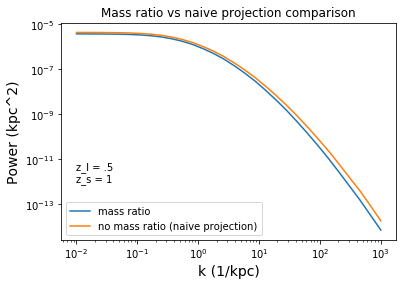

In [73]:
plt.loglog(ps_interlopers[:,0], ps_interlopers[:,1], label='mass ratio')
plt.loglog(ps_interlopers_nomeff[:,0], ps_interlopers_nomeff[:,1], label='no mass ratio (naive projection)')
# makes almost no difference
plt.legend()
plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('Power (kpc^2)', size=14)
plt.title('Mass ratio vs naive projection comparison')
plt.text(1e-2,1e-12, 'z_l = .5\nz_s = 1')
#plt.savefig('imgs/feb28_meff_nomeff.png')

In [55]:
# subhalo mass between 10^5 and 10^8
ps_subhalos = np.array([[0.01, 0.000121185], [0.0125893, 0.000121059], [0.0158489, 
  0.000120874], [0.0199526, 0.000120602], [0.0251189, 
  0.000120206], [0.0316228, 0.000119633], [0.0398107, 
  0.000118812], [0.0501187, 0.000117646], [0.0630957, 
  0.000116014], [0.0794328, 0.000113762], [0.1, 
  0.000110709], [0.125893, 0.00010666], [0.158489, 
  0.000101429], [0.199526, 0.0000948767], [0.251189, 
  0.0000869609], [0.316228, 0.0000777909], [0.398107, 
  0.0000676595], [0.501187, 0.0000570328], [0.630957, 
  0.0000464842], [0.794328, 0.0000365854], [1., 
  0.0000277947], [1.25893, 0.0000203853], [1.58489, 
  0.0000144367], [1.99526, 9.87261e-6], [2.51189, 
  6.51843e-6], [3.16228, 4.15445e-6], [3.98107, 
  2.55575e-6], [5.01187, 1.518e-6], [6.30957, 
  8.71092e-7], [7.94328, 4.83466e-7], [10., 
  2.59889e-7], [12.5893, 1.35523e-7], [15.8489, 
  6.866e-8], [19.9526, 3.38423e-8], [25.1189, 
  1.62472e-8], [31.6228, 7.60478e-9], [39.8107, 
  3.47383e-9], [50.1187, 1.55042e-9], [63.0957, 
  6.77127e-10], [79.4328, 2.89962e-10], [100., 
  1.22047e-10], [125.893, 5.0632e-11], [158.489, 
  2.0762e-11], [199.526, 8.43781e-12], [251.189, 
  3.40664e-12], [316.228, 1.36896e-12], [398.107, 
  5.48347e-13], [501.187, 2.19171e-13], [630.957, 
  8.74764e-14], [794.328, 3.48818e-14], [1000., 1.39011e-14]]) # from Ana's code; also units in kpc

ps_subhalos_48 = np.array([[0.01, 0.000121241], [0.0125893, 0.000121115], [0.0158489, 
  0.00012093], [0.0199526, 0.000120658], [0.0251189, 
  0.000120262], [0.0316228, 0.000119689], [0.0398107, 
  0.000118868], [0.0501187, 0.000117703], [0.0630957, 
  0.00011607], [0.0794328, 0.000113818], [0.1, 
  0.000110765], [0.125893, 0.000106716], [0.158489, 
  0.000101485], [0.199526, 0.0000949323], [0.251189, 
  0.0000870163], [0.316228, 0.0000778461], [0.398107, 
  0.0000677143], [0.501187, 0.000057087], [0.630957, 
  0.0000465376], [0.794328, 0.0000366377], [1., 
  0.0000278455], [1.25893, 0.0000204341], [1.58489, 
  0.000014483], [1.99526, 9.91574e-6], [2.51189, 
  6.55774e-6], [3.16228, 4.18935e-6], [3.98107, 
  2.58582e-6], [5.01187, 1.54304e-6], [6.30957, 
  8.91191e-7], [7.94328, 4.98995e-7], [10., 
  2.71431e-7], [12.5893, 1.43774e-7], [15.8489, 
  7.43338e-8], [19.9526, 3.75936e-8], [25.1189, 
  1.86298e-8], [31.6228, 9.05671e-9], [39.8107, 
  4.3217e-9], [50.1187, 2.02443e-9], [63.0957, 
  9.30753e-10], [79.4328, 4.19908e-10], [100., 
  1.85895e-10], [125.893, 8.07931e-11], [158.489, 
  3.45092e-11], [199.526, 1.45101e-11], [251.189, 
  6.01869e-12], [316.228, 2.46873e-12], [398.107, 
  1.00376e-12], [501.187, 4.05431e-13], [630.957, 
  1.62982e-13], [794.328, 6.53017e-14], [1000., 2.61058e-14]])

ps_subhalos_49 = np.array([[0.01, 0.00151759], [0.0125893, 0.00151195], [0.0158489, 
  0.0015038], [0.0199526, 0.00149217], [0.0251189, 
  0.00147574], [0.0316228, 0.00145281], [0.0398107, 
  0.00142136], [0.0501187, 0.00137903], [0.0630957, 
  0.00132334], [0.0794328, 0.00125209], [0.1, 0.00116385], [0.125893, 
  0.00105867], [0.158489, 0.000938658], [0.199526, 
  0.000808284], [0.251189, 0.000673989], [0.316228, 
  0.00054315], [0.398107, 0.000422629], [0.501187, 
  0.000317478], [0.630957, 0.000230302], [0.794328, 0.000161371], [1.,
   0.00010923], [1.25893, 0.0000714251], [1.58489, 
  0.0000451226], [1.99526, 0.0000275517], [2.51189, 
  0.0000162743], [3.16228, 9.31319e-6], [3.98107, 
  5.17403e-6], [5.01187, 2.7977e-6], [6.30957, 
  1.47657e-6], [7.94328, 7.62869e-7], [10., 
  3.86886e-7], [12.5893, 1.93052e-7], [15.8489, 
  9.49544e-8], [19.9526, 4.60927e-8], [25.1189, 
  2.20941e-8], [31.6228, 1.04577e-8], [39.8107, 
  4.88523e-9], [50.1187, 2.25028e-9], [63.0957, 
  1.02105e-9], [79.4328, 4.55955e-10], [100., 
  2.0027e-10], [125.893, 8.65224e-11], [158.489, 
  3.67917e-11], [199.526, 1.54191e-11], [251.189, 
  6.3807e-12], [316.228, 2.61287e-12], [398.107, 
  1.06115e-12], [501.187, 4.2828e-13], [630.957, 
  1.72079e-13], [794.328, 6.89233e-14], [1000., 2.75476e-14]])

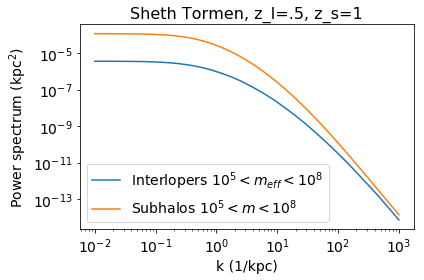

In [74]:
plt.plot(ps_interlopers[:,0], ps_interlopers[:,1], #ps_interlopers_err,
             label='Interlopers $10^5 < m_{eff} < 10^8$')
plt.plot(ps_subhalos[:,0], ps_subhalos[:,1], label='Subhalos $10^5 < m < 10^8$')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('Power spectrum ($\\mathrm{kpc}^2$)', size=14)

plt.gca().tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.title('Sheth Tormen, z_l=.5, z_s=1', size=16)
plt.tight_layout()
#plt.savefig('imgs/feb28_ps_st.png')
plt.show()